In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
import pandas_profiling
from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [ ]:
df = pd.read_csv("/content/Arctic_domain_mean_monthly_1979_2021.csv")
## remove date from the set
df = df.drop('Date', 1)
df.loc[:, 'sea_ice_extent_2'] = df['sea_ice_extent']
df


,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent,sea_ice_extent_2
0,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191,15604191
1,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929,16378929
2,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089,16521089
3,4.792836,1.272056,212.937925,156.223674,0.890723,0.705203,273.126062,259.557456,989.314698,15561238,15561238
4,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613,14085613
...,...,...,...,...,...,...,...,...,...,...,...
507,5.383687,1.529497,225.171796,156.567743,1.159049,0.929777,273.470298,263.146395,985.801841,13840000,13840000
508,4.777020,2.451088,260.956781,229.604138,1.077705,0.575494,273.888627,271.557464,985.606181,12660000,12660000
509,4.771453,4.176458,294.931709,244.702852,1.585094,0.360146,275.245088,278.360921,978.436682,10710000,10710000
510,4.754014,5.193846,313.311345,196.774631,1.957911,0.248088,277.253314,280.413695,978.293303,7690000,7690000


In [ ]:
#Changes made by Sahara 12/6
df1 = df.assign(sea_ice_extent_2 = df.sea_ice_extent_2.shift(-1)).drop(df.index[-1])
df2 = df1.assign(sea_ice_extent_2 = df1.sea_ice_extent_2.shift(-1)).drop(df1.index[-1])
df3 = df2.assign(sea_ice_extent_2 = df2.sea_ice_extent_2.shift(-1)).drop(df2.index[-1])
df4 = df3.assign(sea_ice_extent_2 = df3.sea_ice_extent_2.shift(-1)).drop(df3.index[-1])
df5 = df4.assign(sea_ice_extent_2 = df4.sea_ice_extent_2.shift(-1)).drop(df4.index[-1])
df6 = df5.assign(sea_ice_extent_2 = df5.sea_ice_extent_2.shift(-1)).drop(df5.index[-1])
df6

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent,sea_ice_extent_2
0,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191,10521427.0
1,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929,8183421.0
2,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089,7219913.0
3,4.792836,1.272056,212.937925,156.223674,0.890723,0.705203,273.126062,259.557456,989.314698,15561238,9428492.0
4,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613,11185959.0
...,...,...,...,...,...,...,...,...,...,...,...
501,5.377679,2.472823,259.628479,23.451076,1.719040,1.002086,276.356745,269.301944,981.237639,5591115,13840000.0
502,5.940376,1.667462,233.793937,4.863510,1.747701,1.216300,274.859581,262.026592,973.823627,9476049,12660000.0
503,5.798300,1.145913,205.159064,1.121919,1.279145,0.996564,274.113120,255.205385,982.229939,12254325,10710000.0
504,5.420909,0.948417,194.832163,3.115212,1.017224,0.836702,273.707091,252.237845,986.160552,13480000,7690000.0


##GPR for Lag 1 

In [ ]:
df1

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent,sea_ice_extent_2
0,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191,16378929.0
1,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929,16521089.0
2,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089,15561238.0
3,4.792836,1.272056,212.937925,156.223674,0.890723,0.705203,273.126062,259.557456,989.314698,15561238,14085613.0
4,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613,12653185.0
...,...,...,...,...,...,...,...,...,...,...,...
506,5.494218,1.006108,194.683072,68.315949,1.135685,0.919100,273.414735,254.391240,977.764826,14640000,13840000.0
507,5.383687,1.529497,225.171796,156.567743,1.159049,0.929777,273.470298,263.146395,985.801841,13840000,12660000.0
508,4.777020,2.451088,260.956781,229.604138,1.077705,0.575494,273.888627,271.557464,985.606181,12660000,10710000.0
509,4.771453,4.176458,294.931709,244.702852,1.585094,0.360146,275.245088,278.360921,978.436682,10710000,7690000.0


In [ ]:
data = np.array(df1)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

# print(data.shape)
# print(target.shape)
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing



x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]



In [ ]:
print(y_test[-1])

5750000.0


In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,) # .target.reshape(-1, 1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(481, 10)
(481,)
(30, 10)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train) 
x_test = scaler_x.transform(x_test) 

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1)) 

From the Gaussian process prior, the collection of training points and test points are joint multivariate Gaussian distributed, and so we can write their distribution in this way [1]:
GP prior rewritten: multivariate distribution of training and testing points

Here, K is the covariance kernel matrix where its entries correspond to the covariance function evaluated at observations. Written in this way, we can take the training subset to perform model selection.

In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [ ]:
model.fit(x_train, y_train)
params = model.kernel_.get_params()

In [ ]:
y_pred, std = model.predict(x_test, return_std=True)

In [ ]:
y_train_pred, std = model.predict(x_train, return_std=True)

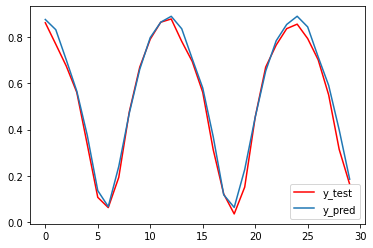

In [ ]:
%matplotlib inline
#plot 
plt.plot(y_test, color='red')
plt.plot(y_pred)

plt.legend(['y_test','y_pred'])
plt.show()


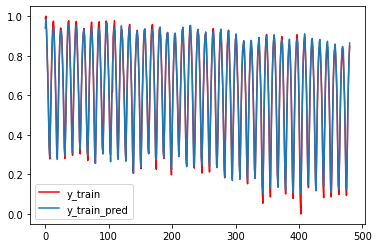

In [ ]:
%matplotlib inline
#plot 
plt.plot(y_train, color='red')
plt.plot(y_train_pred)

plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
#Inverse transformation should be performed after getting predictions

inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)

print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[1.]
[16521089.]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('GPR_lag1.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse1 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse1

452377.0577586787

In [ ]:
nrmse1 = rmse1/(np.mean(inv_y_test))
nrmse1

0.043080040647630095

In [ ]:
r2_score1 = r2_score(inv_y_test, inv_y_pred)

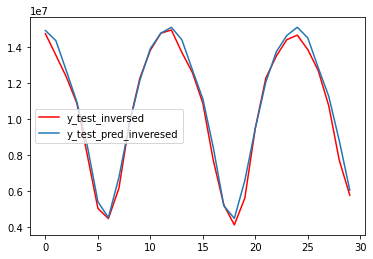

In [ ]:
%matplotlib inline
#plot 
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)

plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()

## GPR for Lag 2

In [ ]:
data = np.array(df2)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

# print(data.shape)
# print(target.shape)
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing



x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(480, 10)
(480,)
(30, 10)
(30,)


In [ ]:
print(y_test[-1])

5750000.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(x_train, y_train)
params = model.kernel_.get_params()
 

In [ ]:
y_pred, std = model.predict(x_test, return_std=True)

In [ ]:
y_train_pred, std = model.predict(x_train, return_std=True)

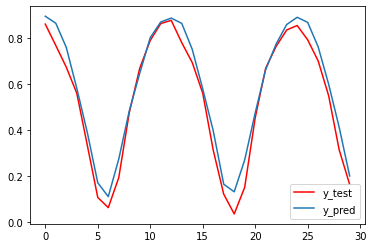

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

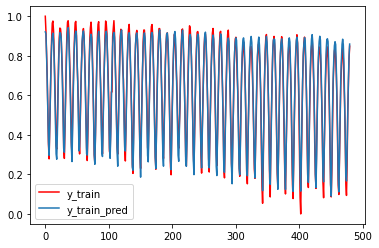

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.92554547]
[15561238.]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('GPR_lag2.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse2 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))

In [ ]:
nrmse2 = rmse2/(np.mean(inv_y_test))
nrmse2

0.07203747069769297

In [ ]:
r2_score2 = r2_score(inv_y_test, inv_y_pred)

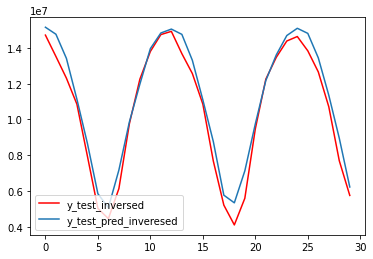

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## GPR for Lag 3

In [ ]:
data = np.array(df3)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

# print(data.shape)
# print(target.shape)
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing



x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(479, 10)
(479,)
(30, 10)
(30,)


In [ ]:
print(y_test[-1])

5750000.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(x_train, y_train)
params = model.kernel_.get_params()
 

In [ ]:
y_pred, std = model.predict(x_test, return_std=True)

In [ ]:
y_train_pred, std = model.predict(x_train, return_std=True)

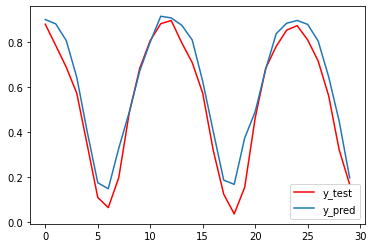

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

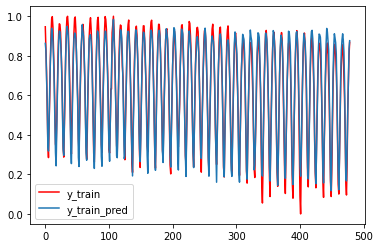

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.82972163]
[14085613.]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

np_file = TemporaryFile()
np.save('GPR_lag3.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse3 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse3

1027093.1099589231

In [ ]:
nrmse3 = rmse3/(np.mean(inv_y_test))
nrmse3

0.09781047063959411

In [ ]:
r2_score3 = r2_score(inv_y_test, inv_y_pred)

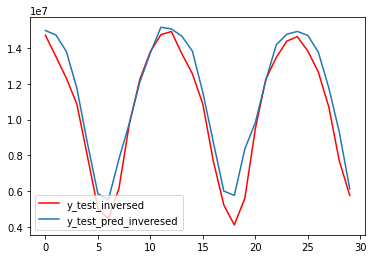

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## GPR for Lag 4

In [ ]:
data = np.array(df4)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(478, 10)
(478,)
(30, 10)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(x_train, y_train)
params = model.kernel_.get_params()
 

In [ ]:
y_pred, std = model.predict(x_test, return_std=True)

In [ ]:
y_train_pred, std = model.predict(x_train, return_std=True)

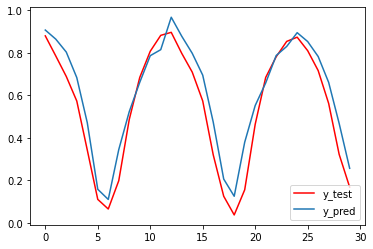

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

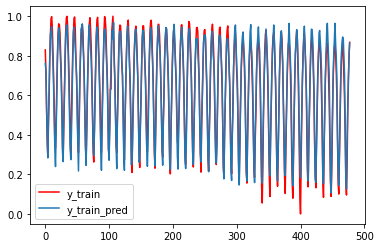

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.7160565]
[12653185.]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('GPR_lag4.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse4 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse4

1168900.5823991958

In [ ]:
nrmse4 = rmse4/(np.mean(inv_y_test))
nrmse4

0.11131485060778323

In [ ]:
r2_score4 = r2_score(inv_y_test, inv_y_pred)

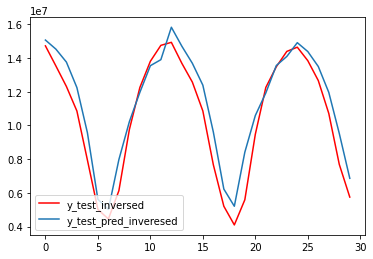

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## GPR for Lag 5

In [ ]:
data = np.array(df5)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(477, 10)
(477,)
(30, 10)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(x_train, y_train)
params = model.kernel_.get_params()
 

In [ ]:
y_pred, std = model.predict(x_test, return_std=True)

In [ ]:
y_train_pred, std = model.predict(x_train, return_std=True)

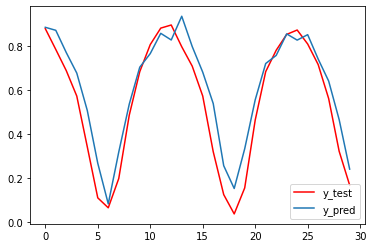

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

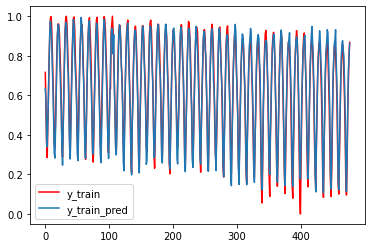

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.54689857]
[10521427.]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('GPR_lag5.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse5 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse5

1257123.650922616

In [ ]:
nrmse5 = rmse5/(np.mean(inv_y_test))
nrmse5

0.11971636724719482

In [ ]:
r2_score5 = r2_score(inv_y_test, inv_y_pred)

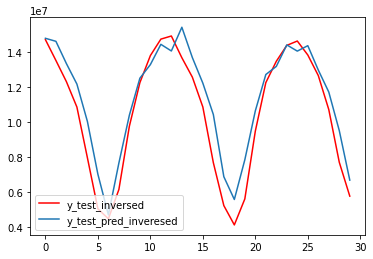

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## GPR for Lag 6

In [ ]:
data = np.array(df6)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(476, 10)
(476,)
(30, 10)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(x_train, y_train)
params = model.kernel_.get_params()
 

In [ ]:
y_pred, std = model.predict(x_test, return_std=True)

In [ ]:
y_train_pred, std = model.predict(x_train, return_std=True)

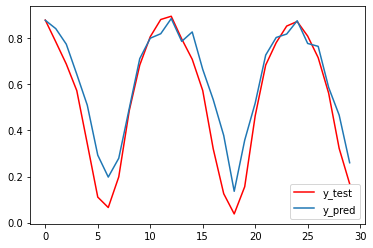

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

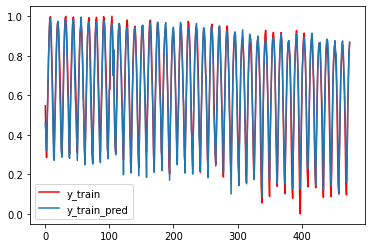

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.36137458]
[8183421.]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('GPR_lag6.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse6 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse6

1319438.5054551405

In [ ]:
nrmse6 = rmse6/(np.mean(inv_y_test))
nrmse6

0.12565063473527857

In [ ]:
r2_score6 = r2_score(inv_y_test, inv_y_pred)

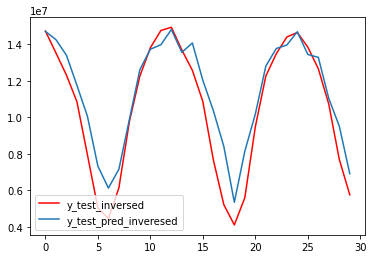

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


In [ ]:
print(rmse1, rmse2, rmse3, rmse4, rmse5, rmse6)

452377.0577586787 756454.6957871105 1027093.1099589231 1168900.5823991958 1257123.650922616 1319438.5054551405


In [ ]:
rmse = [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6]
rmse

[452377.0577586787,
 756454.6957871105,
 1027093.1099589231,
 1168900.5823991958,
 1257123.650922616,
 1319438.5054551405]

In [ ]:
nrmse = [nrmse1, nrmse2, nrmse3, nrmse4, nrmse5, nrmse6]
nrmse

[0.043080040647630095,
 0.07203747069769297,
 0.09781047063959411,
 0.11131485060778323,
 0.11971636724719482,
 0.12565063473527857]

In [ ]:
r2 = [r2_score1, r2_score2, r2_score3, r2_score4, r2_score5, r2_score6]
r2

[0.9839268837897397,
 0.9550567175838058,
 0.9171450283272966,
 0.8926865662217056,
 0.8758762363705522,
 0.8632657699291086]

In [ ]:
from numpy import asarray
from numpy import save
# define data
# data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
# save to npy file
save('rmseForGPR.npy', rmse)
